# Exercice polynômes orthogonaux : application au cas de la déviation verticale de la poutre encastrée

## References
* http://openturns.github.io/openturns/master/user_manual/_generated/openturns.HermiteFactory.html

# Problem statement

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

**Figure 1.** Vertical deviation $Y$ of the cantilever beam of length $L$.

__Inputs__:
* $E$ : Young modulus (Pa)
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4),
* $F$ : Loading (N)

|Variable|  Distribution|
| ------------- |-------------|
|E| Beta(alpha = 0.9, beta = 2.2, a = $2.8\times 10^7$, $b = 4.8\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L| Uniform(min=250, max= 260)|
|I| Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)|

**Table 1.** Marginal distributions of the variables E, F, L and I.

The input variables are supposed to be independent.

## La classe HermiteFactory

In [1]:
import openturns as ot
import numpy as np
import math

La classe `HermiteFactory` permet de créer des polynômes d'Hermite orthonormés par rapport à la densité de probabilité gaussienne.

In [2]:
pofa = ot.HermiteFactory()

La méthode `build` crée un polynôme de degré donné.

In [3]:
for k in range(5):
    print(pofa.build(k))

1
X
-0.707107 + 0.707107 * X^2
-1.22474 * X + 0.408248 * X^3
0.612372 - 1.22474 * X^2 + 0.204124 * X^4


Concentrons-nous sur le polynôme de degré 5. 

In [4]:
pk = pofa.build(5)
pk

<openturns.orthogonalbasis.OrthogonalUniVariatePolynomial; proxy of <Swig Object of type 'OT::OrthogonalUniVariatePolynomial *' at 0x0000024EFF1CC370> >

In [5]:
pk.getDegree()

5

L'opérateur `()` permet d'évaluer le polynôme en un point.

In [6]:
pk(3.0)

1.6431676725155

La méthode `getCoefficients` retourne une table des coefficients du polynôme. Le coefficient correspondant au monôme de plus haut degré est le dernier.

In [7]:
pk.getCoefficients()

class=Point name=Unnamed dimension=6 values=[0,1.36931,-0,-0.912871,0,0.0912871]

Comme chaque polynôme retourné est une fonction, la méthode `draw` permet de le dessiner.

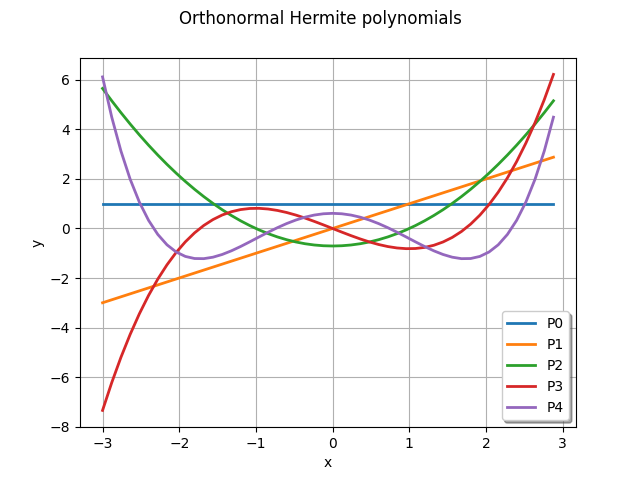

In [8]:
degreemax = 5
graph = ot.Graph("Orthonormal Hermite polynomials", "x", "y", True, "bottomright")
for k in range(degreemax):
    pk = pofa.build(k)
    curve = pk.draw(-3.0, 3.0, 50)
    curve.setLegends(["P%d" % (k)])
    graph.add(curve)
graph

## Les polynômes sont orthonormés pour la densité

Dans OpenTURNS, les polynômes sont orthonormés pour la densité de probabilité. Par conséquent, ils ne sont généralement pas moniques, c'est à dire que le coefficient associé au monôme de plus haut degré n'est pas toujours égal à 1.

Dans la boucle `for` suivante, on considère les polynômes d'Hermite de degré 0 à 5. Pour chaque degré, on affiche le coefficient du monôme de plus grand exposant, son inverse ainsi que le facteur $\frac{1}{\sqrt{k!}}$. On observe que les deux sont égaux.

In [9]:
print("Leading coefficient:")
for k in range(degreemax):
    pk = pofa.build(k)
    leadingCoeffOT = pk.getCoefficients()[-1]
    leadingCoeffReference = 1.0 / np.sqrt(math.factorial(k))
    print(f"OT = {leadingCoeffOT:.4f}, ref. = {leadingCoeffReference:.4f}")

Leading coefficient:
OT = 1.0000, ref. = 1.0000
OT = 1.0000, ref. = 1.0000
OT = 0.7071, ref. = 0.7071
OT = 0.4082, ref. = 0.4082
OT = 0.2041, ref. = 0.2041


## La récurrence à trois termes

La méthode `getRecurrenceCoefficients` permet d'obtenir les coefficients de la récurrence à trois termes permettant d'évaluer les polynômes orthonormaux :
$$
P_{n+1}(x) = (a_{0,n} x + a_{1,n}) P_n(x) + a_{2,n} P_{n-1}(x)
$$
pour $n\neq 0$ et tout $x\in\mathbb{R}$, où $P_n$ est le polynôme de degré $n$ et $(a_{0,n},a_{1,n},a_{2,n})$ sont ces coefficients. En d'autres termes, la méthode `getRecurrenceCoefficients(n)` retourne les coefficients $(a_{0,n},a_{1,n},a_{2,n})$ permettant de calculer $P_{n+1}$ en fonction de $P_n$ et $P_{n-1}$. 

In [10]:
for n in range(5):
    print(pofa.getRecurrenceCoefficients(n))

[1,0,0]
[0.707107,0,-0.707107]
[0.57735,0,-0.816497]
[0.5,0,-0.866025]
[0.447214,0,-0.894427]


## Définir des polynômes univariés de manière automatique

Dans cette partie, on montre comment définir des polynômes univariés dans le cas de la poutre encastrée. Nous voyons comment créer la famille de polynômes orthogonaux associé à une variable aléatoire. Nous analysons la mesure associée à une famille de polynômes orthogonaux et montrons comment dessiner les polynômes.

Pour commencer, on définit une variable aléatoire de loi uniforme.

In [11]:
distributionL = ot.Uniform(250.0, 260.0)  # in cm

Puis on crée le polynôme univarié associé à cette variable avec la classe `StandardPolynomialFactory`.

In [12]:
factory_L = ot.StandardDistributionPolynomialFactory(distributionL)
factory_L

class=StandardDistributionPolynomialFactory hasSpecificFamily=true specificFamily=class=OrthogonalUniVariatePolynomialFamily implementation=class=LegendreFactory measure=class=Uniform name=Uniform dimension=1 a=-1 b=1

On observe que les polynômes orthogonaux associés à la loi uniforme sont les polynômes de Legendre.

Pour générer le polynôme de degré zéro associée à cette famille, on utilise la méthode `build`.

In [13]:
P0 = factory_L.build(0)
P0

<openturns.orthogonalbasis.OrthogonalUniVariatePolynomial; proxy of <Swig Object of type 'OT::OrthogonalUniVariatePolynomial *' at 0x0000024E9B22C9B0> >

Pour toute famille de polynômes orthogonaux, le polynôme de degré zéro est toujours égal à 1. Observons les polynômes de degrés 0 à 5 :

In [14]:
for i in range(5):
    Pi = factory_L.build(i)
    print(Pi)

1
1.73205 * X
-1.11803 + 3.3541 * X^2
-3.96863 * X + 6.61438 * X^3
1.125 - 11.25 * X^2 + 13.125 * X^4


Pour toute famille de polynômes orthogonaux, on *standardise* la densité de probabilité pour obtenir une famille dont les paramètres sont constants : dans OpenTURNS, on nomme cette distribution la *mesure*. La méthode `getMeasure` permet de l'obtenir :

In [15]:
measure = factory_L.getMeasure()
measure

class=Uniform name=Uniform dimension=1 a=-1 b=1

Comme cette distribution est uniforme, on peut facilement obtenir les bornes associées avec la methode `getRange`. 

In [16]:
Lrange = measure.getRange()
Lmin = Lrange.getLowerBound()[0]
Lmax = Lrange.getUpperBound()[0]
print(Lmin)
print(Lmax)

-1.0
1.0


On souhaite ensuite dessiner le polynôme orthogonal de degré 6 : on utilise la méthode `draw`.

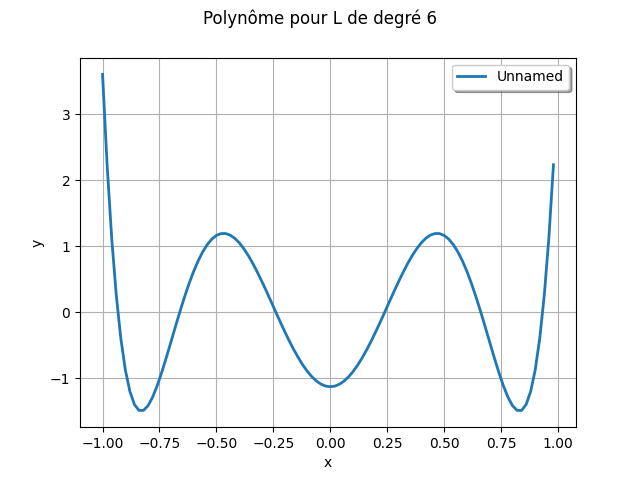

In [17]:
P6 = factory_L.build(6)
graph = P6.draw(Lmin, Lmax, 100)
graph.setTitle("Polynôme pour L de degré 6")
graph

## Exercice 1 : vérifier la récurrence à trois termes pour les polynômes d'Hermite

L'objectif de cet exercice est de vérifier la récurrence à trois termes des polynômes orthogonaux.
En effet, si $(P_n)_{n\geq 0}$ est une famille de polynômes orthonormaux, alors :

$$
P_{n+1}(x) = (a_{0,n} x + a_{1, n}) P_n(x) + a_{2,n} P_{n - 1}(x),
$$

pour $n\geq 0$ et tout point $x\in  \mathbb{R}$ où $a_{0,n}$, $a_{1,n}$ et $a_{2,n}$ sont des coefficients.


La fonction `evalPolynomialFactory` suivante utilise la formule de récurrence à trois termes pour évaluer les polynômes d'Hermite. 
- Dans une boucle `for`, elle appele la méthode `getRecurrenceCoefficients` pour obtenir les coefficients de la récurrence $(a_{0,n},a_{1,n},a_{2,n})$. 
- Puis elle utilise la formule de récurrence pour calculer $P_{n+1}$ en fonction de $P_n$ et $P_{n-1}$. 

In [18]:
def evalPolynomialFactory(x, polyfact, degree):
    """
    Evaluates the orthogonal polynomial with given degree.

    The code uses the three-term recurrence:

        P{n+1}(x) = (a0n * x + a1n) * P{n}(x) + a2n * P{n-1}(x)

    Parameters
    ----------
    x : float
        The point where the polynomial must be evaluated.
    polyfact : ot.OrthogonalUniVariatePolynomial()
        A family of orthonormal polynomials.
    degree : int
        The polynomial degree.

    Returns
    -------
    p : float
        The polynomial value at point x.

    """
    if degree == 0:
        p = 1.0
    else:
        pp = 0.0  # Previous : P{n-1}
        pc = 1.0  # Current : Pn
        for n in range(degree):
            # Evalue P{n+1}(x) en fonction de Pn et P{n-1}
            a0, a1, a2 = polyfact.getRecurrenceCoefficients(n)
            p = (a0 * x + a1) * pc + a2 * pp
            pp = pc
            pc = p
    return p

L'objectif de l'exercice est de valider la fonction `evalPolynomialFactory` en comparant ses sorties avec celles du polynôme.

**Questions.**

- En utilisant la fonction `linearSample`, créer la variable `x` contenant une liste de `npoints = 5` abscisses régulièrement réparties entre -3 et 3. 
- Puis, réaliser une boucle `for` sur les degrés $k$ de 0 à 5. 
- Pour chaque degré `k`, créer le polynôme `pk` de degré `k`, puis réaliser une boucle sur les indices `i` des abscisses contenues dans la variable `x`.
- Pour chaque abscisse, évaluer le polynôme `pk` avec son opérateur `()` et comparer avec la valeur de la fonction `evalPolynomialFactory`.


In [19]:
def linearSample(xmin, xmax, npoints):
    """Returns a sample created from a regular grid
    from xmin to xmax with npoints points."""
    step = (xmax - xmin) / (npoints - 1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices


Pour vous aider, vous pouvez vous inspirer du squelette suivant, dans lequel vous remplacerez les sections *TODO* par du code Python valide.

```python
npoints = 5
x = linearSample(-3.0, 3.0, npoints)
for k in range(5):
    print("Degree = %d" % (k))
    pk = pofa.build(TODO)
    for i in range(npoints):
        y = evalPolynomialFactory(TODO)
        ytrue = TODO
        print("x=%f, y=%f, True y = %f" % (x[i,0 ], y, ytrue))
```

## Exercice 2 : vérification de l'orthornormalité des polynômes

L'objectif de cet exercice est d'observer l'orthonormalité des polynômes par rapport à la densité de probabilité associée. 
On souhaite vérifier que le produit scalaire :
$$
\left\langle P_j, P_k \right\rangle = \int_\mathbb{R} P_j(x) P_k(x) f(x) dx 
$$
satisfait l'égalité :
$$
\left\langle P_j, P_k \right\rangle = \delta_{jk}
$$
pour $j,k= 0,...,5$ où $\delta_{jk}$ est le symbole de Kronecker.

Pour cela, nous définissons la fonction `FactoryScalarProductIntegrand` qui évalue la fonction $P_j(x) P_k(x) f(x)$ pour tout $x\in\mathbb{R}$.

In [ ]:
class FactoryScalarProductIntegrand(ot.OpenTURNSPythonFunction):
    def __init__(self, functionFactory, j, k):
        super().__init__(1, 1)
        self.measure = functionFactory.getMeasure()
        self.functionJ = functionFactory.build(j)
        self.functionK = functionFactory.build(k)

    def _exec(self, x):
        """
        Evaluates functionJ(x) * functionK(x) * f(x) for the measure PDF at point x.

        This function is the integrand to consider when
        we want to check that the functions in the basis are orthogonal.

        Parameters
        ----------
        x : ot.Point(1)
            The point.

        Returns
        -------
        y : list(float)
            The integrand value.

        """
        pdf = self.measure.computePDF(x)
        yf = self.functionJ(x[0]) * self.functionK(x[0]) * pdf
        return [yf]


Pour évaluer l'intégrale, nous proposons d'utiliser la règle de Gauss-Kronrod implémentée dans la classe `GaussKronrodRule`. 

In [21]:
gkr = ot.GaussKronrodRule(ot.GaussKronrodRule.G11K23)
algo = ot.GaussKronrod(1000, 1e-16, gkr)

Il est nécessaire de fixer des bornes finies pour évaluer l'intégrale. Nous savons que la densité de probabilité de la loi gaussienne centrée et réduite est numériquement égale à zéro en dehors de l'intervalle [-38,38].

In [22]:
hermitePolynomials = ot.HermiteFactory()
integrandPiJPiKFPy = ot.Function(FactoryScalarProductIntegrand(hermitePolynomials, 0, 1))
measure = hermitePolynomials.getMeasure()
measure.computePDF(ot.Sample([[x] for x in [-38.0, -37.0, 37.0, 38.0]]))

,v0
0,1.097221e-314
1,2.120007e-298
2,2.120007e-298
3,1.097221e-314


C'est pour cette raison que nous fixons ainsi les bornes de l'intervalle d'intégration.

In [23]:
bounds = ot.Interval(-38.0, 38.0)

Le produit scalaire peut alors être calculé avec les instructions :
```python
pscalJK = algo.integrate(integrandPiJPiKFPy, bounds)[0]
```



**Questions.**

- Réaliser une boucle sur les indices `j` et `k` entre 0 et 5 et évaluer le produit scalaire : qu'observez-vous ?

## Exercice 3 : orthonormalisation d'une densité de probabilité

La classe `AdaptiveStieltjesAlgorithm` propose un algorithme pour générer la base orthonormale associée à une densité de probabilité donnée. Sur le principe, cette classe réalise l'algorithme de Gram-Schmidt pour générer la base orthonormale à partir de la base canonique. L'implémentation repose en fait sur un algorithme plus précis sur le plan numérique, en particulier pour les polynômes de dégré élevés.

L'objectif de cet exercice est de comparer les polynômes obtenus par la classe `AdaptiveStieltjesAlgorithm` pour la loi uniforme avec les polynômes de Legendre.

**Questions.**

* Dans un premier temps, on utilise l'algorithme d'orthonormalisation.
  * Créer la variable `measure` contenant une variable uniforme standard.
  * Utiliser la classe `AdaptiveStieltjesAlgorithm` pour créer un algorithme d'orthonormalisation `algo`.
  * Utiliser la classe `StandardDistributionPolynomialFactory` pour créer la variable `pofa` sur cet algorithme.
  * Utiliser la méthode `build` pour afficher les polynômes de degrés 0 à 4 correspondants.
* Dans un second temps, on utilise les polynômes de Legendre.
  * Utiliser la classe `LegendreFactory` pour créer la variable `lefa`.
  * Utiliser la variable `lefa` pour afficher les polynômes de Legendre de degrés 0 à 4 correspondants.
* Comparer les deux résultats : qu'observez-vous ?

TODO : étendre l'exercice en utilisant l'algorithme de Gram-Schmidt. Constater son échec lorsque le degré polynomial augmente.

## Exercice 4 : polynômes orthogonaux pour une variable gaussienne

**Questions.**

* Créer la famille de polynômes orthogonaux associés à une variable $X$ de loi normale de moyenne 12 et d'écart-type 3.4 :
```python
N = ot.Normal(12.0, 3.4)
```
* Quelle est la famille de polynômes orthogonaux associés à cette variable ?
* Afficher les polynômes de degrés 0 à 5 associés.
* Quelle est la mesure standard associée ?
* On souhaite dessiner le polynôme de degré 6 associé à cette mesure : pourquoi ne peut-on pas utiliser la méthode `getRange` pour déterminer les bornes ? 
* Utiliser la méthode `computeBilateralConfidenceInterval` pour déterminer l'intervalle de confiance à 95% : en déduire des bornes pour dessiner le polynôme.
* Dessiner le polynôme de degré 6 associé à cette mesure.

## Exercice 5 : polynômes orthogonaux pour la variable F

**Questions.**

* Créer la famille de polynômes orthogonaux associés à la variable $F$ :
```python
parametersF = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
distributionF = ot.ParametrizedDistribution(parametersF)
```
* Quelle est la famille de polynômes orthogonaux associés à cette variable ?
* Afficher les polynômes de degrés 0 à 5 associés.
* Quelle est la mesure standard associée ?
* On souhaite dessiner le polynôme de degré 6 associé à cette mesure : pourquoi ne peut-on pas utiliser la méthode `getRange` pour déterminer les bornes ? 
* Utiliser la méthode `computeBilateralConfidenceInterval` pour déterminer l'intervalle de confiance à 95% : en déduire des bornes pour dessiner le polynôme.
* Dessiner le polynôme de degré 6 associé à cette mesure.